In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import geopandas as gpd

import cartopy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial
from plotter import draw_basemap, plot_terrain, plot_sensitivity_cbar
from trajectory import calculate_backward_trajectory
import customcmaps as ccmaps
from utils import roundPartial, select_months_ds


dask.config.set(**{'array.slicing.split_large_chunks': True})

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load the trajectories from the March 2003 storm
start_mon = 1
end_mon = 12

## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
PRISM = select_months_ds(PRISM, start_mon, end_mon, 'date')
HUC8_lst = PRISM.HUC8.values ## get list of HUC8 IDs

## a quick function that assigns each watershed a basin value 
## based on the first 2 numbers of the HUC8 identifier

basin_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    HUC2 = HUC8_ID[:2]
    if HUC2 == '14':
        basin = 'Colorado'
    elif HUC2 == '13':
        basin = 'Rio Grande'
    elif HUC2 == '11':
        basin = 'Arkansas'
    elif HUC2 == '10':
        basin = 'South Platte'
   
    basin_lst.append(basin)
    
ds_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    fname = path_to_data +'preprocessed/ERA5_trajectories/combined_extreme_AR/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    ds = xr.open_dataset(fname)
    ds_lst.append(ds)
    
## concat ds_lst along HUC8 index
ds = xr.concat(ds_lst, pd.Index(HUC8_lst, name="HUC8"))
## add the basin name as a coord
ds = ds.assign_coords({'basin': ("HUC8", basin_lst)})

## subset to case study date
ds = ds.sel(start_date=slice('2003-03-17 00', '2003-03-19 06'))
# ds = ds.sel(start_date=slice('2017-01-09 00', '2019-01-11  06')) # yes
# ds = ds.sel(start_date=slice('2013-09-10 00', '2013-09-12  06')) # no
# ds = ds.sel(start_date=slice('2019-03-12 00', '2019-03-15  06')) # yes
ds

<xarray.Dataset>
Dimensions:             (index: 72, start_date: 3, HUC8: 92)
Coordinates:
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
  * start_date          (start_date) datetime64[ns] 2003-03-17 ... 2003-03-19
    time                (HUC8, start_date, index) datetime64[ns] 2003-03-17 ....
    lon                 (HUC8, start_date, index) float64 -108.5 ... -132.0
    lat                 (HUC8, start_date, index) float64 37.18 37.08 ... 34.35
  * HUC8                (HUC8) object '14080107' '14080105' ... '10250013'
    basin               (HUC8) <U12 'Colorado' 'Colorado' ... 'South Platte'
Data variables: (12/18)
    level               (HUC8, start_date, index) float64 700.0 696.5 ... 560.3
    q                   (HUC8, start_date, index) float64 4.123 4.239 ... 0.132
    u                   (HUC8, start_date, index) float64 5.143 7.711 ... 20.55
    v                   (HUC8, start_date, index) float64 3.046 3.505 ... -4.2
    w                   (HUC8, start_date, index) float64 0.09767 ... 0.1527
    IVT                 (HUC8, start_date, index) float64 53.58 71.11 ... 181.0
    ...                  ...
    coastal_IVT         (HUC8, start_date) float64 382.6 nan nan ... nan 355.3
    ar_scale_strict     (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar_strict           (HUC8, start_date) float64 0.0 nan nan ... nan nan 0.0
    tARget_strict       (HUC8, start_date) float64 2.003e+11 nan nan ... nan nan
    coastal_IVT_strict  (HUC8, start_date) float64 132.7 nan nan ... nan 95.19
    time_match          (HUC8, start_date) object '2003-03-16 01' ... '2003-0...

In [4]:
print(np.nanmax(ds.ar_scale.values))

3.0


In [9]:
tmp = ds.where(ds.tARget.isnull(), drop=True)
tmp

<xarray.Dataset>
Dimensions:             (HUC8: 92, start_date: 3, index: 72)
Coordinates:
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
  * start_date          (start_date) datetime64[ns] 2003-03-17 ... 2003-03-19
    time                (HUC8, start_date, index) datetime64[ns] 2003-03-17 ....
    lon                 (HUC8, start_date, index) float64 -108.5 ... -132.0
    lat                 (HUC8, start_date, index) float64 37.18 37.08 ... 34.35
  * HUC8                (HUC8) object '14080107' '14080105' ... '10250013'
    basin               (HUC8) <U12 'Colorado' 'Colorado' ... 'South Platte'
Data variables: (12/18)
    level               (HUC8, start_date, index) float64 nan nan ... nan nan
    q                   (HUC8, start_date, index) float64 nan nan ... nan nan
    u                   (HUC8, start_date, index) float64 nan nan ... nan nan
    v                   (HUC8, start_date, index) float64 nan nan ... nan nan
    w                   (HUC8, start_date, index) float64 nan nan ... nan nan
    IVT                 (HUC8, start_date, index) float64 nan nan ... nan nan
    ...                  ...
    coastal_IVT         (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar_scale_strict     (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar_strict           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    tARget_strict       (HUC8, start_date) float64 nan nan nan ... nan nan nan
    coastal_IVT_strict  (HUC8, start_date) float64 nan nan nan ... nan nan nan
    time_match          (HUC8, start_date) object nan nan nan ... nan nan nan

In [6]:
# HUC8_lst = ['14050001', ## upper yampa
#                '13010001', ## rio grande headwaters
#                '10190002', ## 'Upper South Platte'
#                '11020001' ## Arkansas Headwaters
#               ]

# ds = ds.sel(HUC8=HUC8_lst)
# ds

In [7]:
# ## Load subbasin watershed file
# path_to_data = '/expanse/nfs/cw3e/cwp140/'
# fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
# polys = gpd.read_file(fp, crs="epsg:4326") # have to manually set the projection


# idx = (polys.HUC8 == str(HUC8_lst[0])) | (polys.HUC8 == str(HUC8_lst[1])) | (polys.HUC8 == str(HUC8_lst[2])) | (polys.HUC8 == str(HUC8_lst[3]))
# polys =  polys[idx]
# polys

In [10]:
## load geopotential height data
yr = '2003'
mon = '03'
fname = path_to_data + 'downloads/ERA5/{0}{1}_z_prs.nc'.format(yr, mon)
gph = xr.open_dataset(fname)

# if yr == '2003':
#     idx = (gph.time.dt.hour == 0)
#     gph = gph.sel(time=idx, level=700)
# else:
idx = (gph.valid_time.dt.hour == 0)
gph = gph.sel(valid_time=idx, pressure_level=700)
gph

<xarray.Dataset>
Dimensions:         (valid_time: 3, latitude: 721, longitude: 1440)
Coordinates:
    number          int64 ...
  * valid_time      (valid_time) datetime64[ns] 2003-03-17 2003-03-18 2003-03-19
    pressure_level  float64 700.0
  * latitude        (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude       (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver          (valid_time) <U4 ...
Data variables:
    z               (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-18T21:11 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
## create tick labels 'YYYY-MM-DD HH'
t_lst = []
for m, start_date_val in enumerate(tmp.start_date.values):
    ts = pd.to_datetime(str(start_date_val)) 
    t = ts.strftime('%Y-%m-%d %HZ')
    t_lst.append(t)
# ["{:.0%}".format(i) for i in cbax.get_ticks()]
t_lst

['2003-03-17 00Z', '2003-03-18 00Z', '2003-03-19 00Z']

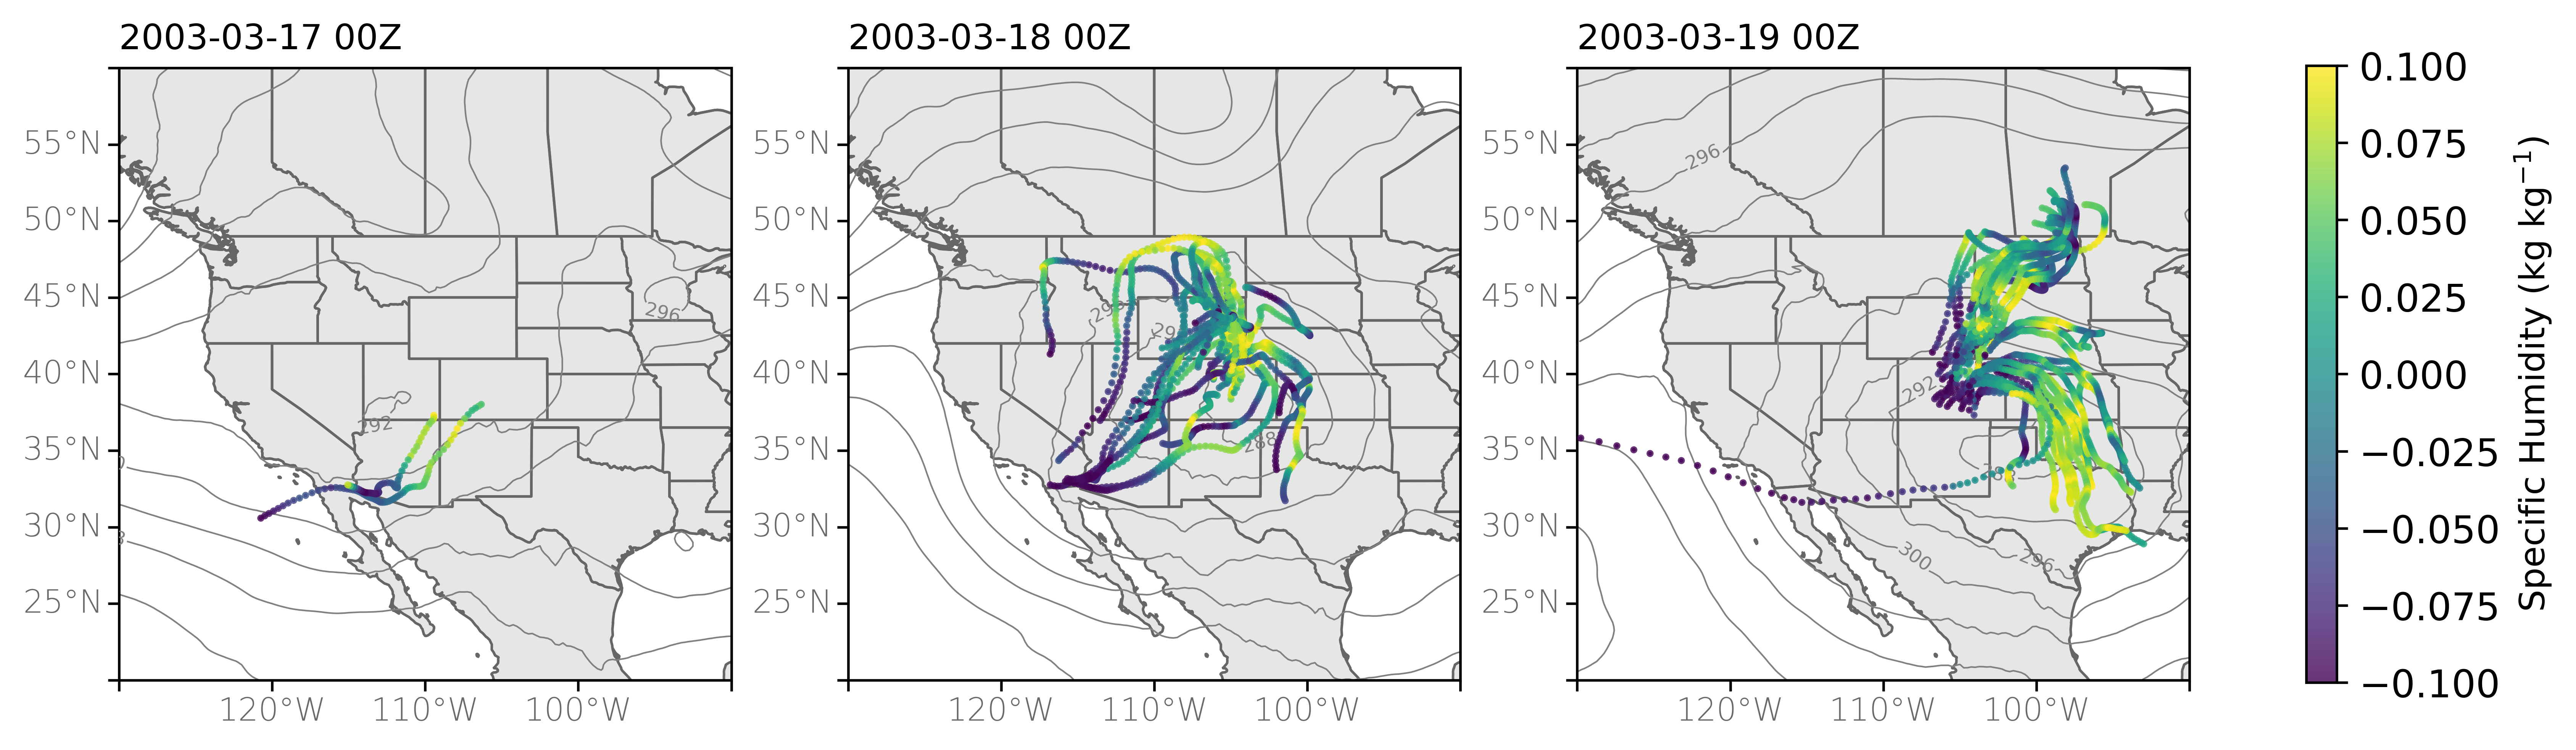

In [12]:
ext = [-130., -90., 20., 60.] 
fmt = 'png'
nrows = 1
ncols = 4
# colors = ['#ffffcc', '#a1dab4', '#41b6c4', '#225ea8']

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

fig = plt.figure(figsize=(12.5 ,3.5))
fig.dpi = 600
fname = '../figs/cyclone_workshop_trajectories_null'

cmap = cmo.deep
bnds = np.arange(0, 6.25, .25)
norm = mcolors.BoundaryNorm(bnds, cmap.N)

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1, 1, 1, 0.05], wspace=0.25, hspace=0.05)
## use gs[rows index, columns index] to access grids

left_lats = [True, False, False, False]
## each 6 hours gets its own plot
for i, start_date_val in enumerate(tmp.start_date.values):
    ax = fig.add_subplot(gs[0, i], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=True, right_lats=False)
    ax.set_extent(ext, datacrs)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

    ## add geopotential height contours
    gph_data = gph.isel(valid_time=i)
    clevs_hgts = np.arange(0,8000,4)
    z = gph_data.z.values / 9.80665 # convert from geopotential to geopotential height in m
    cs = ax.contour(gph.longitude.values, gph.latitude.values, z/10., transform=datacrs,
                levels=clevs_hgts, colors='grey', linewidths=0.5)
    plt.clabel(cs, fmt='%d',fontsize=6, inline_spacing=5)  
    ax.set_title(t_lst[i], loc='left', fontsize=11)
        
    ## start with start date and level
    data = tmp.sel(start_date=start_date_val)
    
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)
    for m, HUC8 in enumerate(data.HUC8.values):
        d = data.sel(HUC8=HUC8)
        y_lst = d.lat.values
        x_lst = d.lon.values
        z_lst = d.q.values
        cf = ax.scatter(x_lst, y_lst, c=z_lst, marker='.', transform=datacrs, alpha=0.8, s=6, zorder=100)

    # ## add in four focus watersheds
    # polys.plot(ax=ax, edgecolor='white', color='None', zorder=99)
    
# Add color bar
cbax = plt.subplot(gs[0,-1]) # colorbar axis
# cbarticks = [100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600]
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('Specific Humidity (kg kg$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)
# kw_ticklabels = {'size': 8, 'color': 'dimgray', 'weight': 'light'}
# cbax.set_xticklabels(HUC8_lbl, **kw_ticklabels)  # horizontally oriented colorbar

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()